In [ ]:
import tensorflow as tf
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import mvn
import matplotlib.pyplot as plt
import math
from itertools import product,chain
import os

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


# **Train or Load MNIST**

In [ ]:
def load_mnist():
	mnist = tf.keras.datasets.mnist
	(x_train, y_train), (x_test, y_test) = mnist.load_data()
	x_train, x_test = x_train / 255.0, x_test / 255.0

	return x_train, x_test, y_train, y_test

In [ ]:
def getFNN_model(x_train, y_train):
	path = f'./FNN/mnist-125K'
	if(os.path.exists(path)):
		probability_model = tf.keras.models.load_model(path)
		print(probability_model.summary())
		return probability_model

	probability_model = tf.keras.models.Sequential([
		tf.keras.layers.Flatten(input_shape=(28, 28)),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.Dense(100, activation='relu'),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.Dense(70, activation='relu'),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.Dense(50, activation='relu'),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.Dense(30, activation='relu'),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.Dense(10),
		tf.keras.layers.Softmax()
	])

	print(probability_model.summary())

	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

	probability_model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

	probability_model.fit(x_train, y_train, epochs=5)

	print(probability_model.evaluate(x_test,  y_test, verbose=2))
	probability_model.save(path)
	return probability_model


In [ ]:
def getCNN_model():
	path = f'./CNN/mnist-60K'
	if(os.path.exists(path)):
		probability_model = tf.keras.models.load_model(path)
		print(probability_model.summary())
		return probability_model

	probability_model = tf.keras.models.Sequential()
	probability_model.add(tf.keras.layers.Conv2D(16, (4, 4), activation='relu', strides = (2,2), input_shape=(28, 28, 1)))
	probability_model.add(tf.keras.layers.Conv2D(32, (4, 4), activation='relu', strides = (2,2)))
	probability_model.add(tf.keras.layers.Flatten())
	probability_model.add(tf.keras.layers.Dense(64, activation='relu'))
	probability_model.add(tf.keras.layers.Dense(10))
	probability_model.add(tf.keras.layers.Softmax())
	print(probability_model.summary())

	probability_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

	history = probability_model.fit(x_train, y_train, epochs=1,
                    validation_data=(x_test, y_test))

	probability_model.save(path)

# **Perturbation Layers**

In [ ]:
class add_Layer(tf.keras.layers.Layer):
  def __init__(self, weights, **kwargs):
    super(add_Layer, self).__init__(**kwargs)
    self.initial_weights = weights

  def build(self, input_shape):
    super(add_Layer, self).build(input_shape)

  def call(self, input):
    output = tf.math.add(input,self.initial_weights)
    return output

In [ ]:
class mult_Layer(tf.keras.layers.Layer):
  def __init__(self, weights, **kwargs):
    super(mult_Layer, self).__init__(**kwargs)
    self.initial_weights = weights

  def build(self, input_shape):
    super(mult_Layer, self).build(input_shape)

  def call(self, input):
    output = tf.math.multiply(input,self.initial_weights)
    return output

In [ ]:
def s_t_d(x_0: np.ndarray, xi: int, dx_init: float, bgcolor=0.0):
  """Translation is linear interpolation from the source pixel to the target pixel.
  """
  x_init = int(dx_init*28)
  source_x = xi%28 - x_init
  source_y = int(xi/28)
  target_x = source_x - 1
  target_y = source_y
  source_xi = (source_x + source_y*28) if source_x >= 0 else -9999
  target_xi = target_x + target_y*28 if target_x >= 0 else -9999
  source_pixel = x_0[source_xi] if source_xi >= 0 else bgcolor
  target_pixel = x_0[target_xi] if target_xi >= 0 else bgcolor
  diff_pixel = target_pixel - source_pixel

  return source_xi, target_xi, diff_pixel

In [ ]:
def on_mask(xi: int) -> bool:
  return 5 <= int(xi/28) < 10 and 5 <= xi%28 < 10

def create_perturbation_model(x_0, param = (1.0, 1.0), init = (0.0, 0.0), kinds = ('light', 'mask_c')):
  max_pixel = 1.0
  safety_radius = 0.0
  ndim = len(x_0)*len(x_0[0])
  pdim = len(param)
  need_clip_ki = -1
  flat_x0 = tf.reshape(x_0, [ndim])
  for ki,kind in enumerate(kinds):
    if kind in ('light', 'mask_c') and (param[ki] != 0.0 or init[ki] != 0.0):
      need_clip_ki = ki

  model = tf.keras.Sequential();
  ## Image: pdim -> pdim + ndim
  model.add(tf.keras.Input(shape=(pdim,)))

  W = tf.constant(np.eye(pdim).tolist() + [[0.0]*pdim]*ndim)
  B = tf.concat([tf.cast(tf.zeros(2), tf.float64), flat_x0], 0)

  model.add(tf.keras.layers.Dense((pdim + ndim), weights = [tf.transpose(W), B]))
  #model.layers[-1].setWeights([tf.constant(np.eye(pdim).tolist() + [[0.0]*pdim]*len(x_0)), tf.constant([0.0]*pdim + x_0.tolist())])


  # Layer_ki: pdim_pre + ndim --> pdim_post + ndim
  for ki, kind in enumerate(kinds):
    prefix = f'Perturbation-{ki}_{kind}'
    pdim_pre = pdim - ki
    pdim_post = pdim_pre - 1
    ##########

    if kind == 'none':
      W = [[(
              1.0 if xj == xi + 1 else # Copy each input.
              0.0
            ) for xj in range(pdim_pre + ndim)
          ] for xi in range(pdim_post + ndim)]

      B = [(
             init[ki] if xj == 0 else # Initialize this parameter.
             0.0
           ) for xj in range(pdim_pre + ndim)]

      model.add(add_Layer(weights = [B]))
      model.add(tf.keras.layers.Dense((pdim_post + ndim), weights = [tf.transpose(tf.constant(W)), tf.zero(pdim_post + ndim)]))
      #model.layers[0]/ui/v1/icons/mail/google_workspace_2x.png.setWeights([tf.constant(W), tf.constant(B)])

    elif kind == 'light':
      W = [[(
              (param[ki]*max_pixel) if xj == 0      and pdim_post <= xi else # Perturb pixels.
              1.0                   if xj == xi + 1                     else # Copy the others.
              0.0
            ) for xj in range(pdim_pre + ndim)
          ] for xi in range(pdim_post + ndim)]

      B = [(
             init[ki] if xj == 0 else # Initialize this parameter.
             0.0
           ) for xj in range(pdim_pre + ndim)]

      model.add(add_Layer(weights = B))
      model.add(tf.keras.layers.Dense((pdim_post + ndim), weights = [tf.transpose(tf.constant(W)), tf.zeros(pdim_post + ndim)]))
      #model.layers[-1].setWeights([tf.constant(W), tf.constant(B)])


    elif kind == 'mask_c':
      W = [[(
              (param[ki]*max_pixel) if xj == 0      and on_mask(xi-pdim_post) else # Perturb pixels.
              1.0                   if xj == xi + 1                           else # Copy the others.
              0.0
            ) for xj in range(pdim_pre + ndim)
          ] for xi in range(pdim_post + ndim)]

      B = [(
             init[ki] if xj == 0 else # Initialize this parameter.
             0.0
           ) for xj in range(pdim_pre + ndim)]

      model.add(add_Layer(weights = B))
      model.add(tf.keras.layers.Dense((pdim_post + ndim), weights = [tf.transpose(tf.constant(W)), tf.zeros(pdim_post + ndim)]))
      #model.layers[-1].setWeights([tf.constant(W), tf.constant(B)])

    elif kind == 'shift_x':
      W = [[(
              (param[ki]*s_t_d(flat_x0, xi-pdim_post, init[ki])[2]) if xj == 0                                              and pdim_post <= xi else # Perturb pixels.
              1.0                                               if xj == xi + 1                                         and xi < pdim_post  else # Copy other params.
              1.0                                               if xj-pdim_pre == s_t_d(flat_x0, xi-pdim_post, init[ki])[0] and pdim_post <= xi else # Copy source pixels.
              0.0
            ) for xj in range(pdim_pre + ndim)
          ] for xi in range(pdim_post + ndim)]

      model.add(tf.keras.layers.Dense((pdim_post + ndim), weights = [tf.transpose(tf.constant(W)), tf.zeros(pdim_post + ndim)]))
      #model.layers[-1].setWeights([tf.constant(W), tf.zeros(pdim_post + ndim)])


    ##########
    # Clipping onto [0,max_pixel]: ndim -> ndim
    if ki == need_clip_ki:
      nrelus = pdim_post + ndim

      model.add(add_Layer(weights = tf.constant([safety_radius]*nrelus)))
      model.add(tf.keras.layers.ReLU())
      model.add(add_Layer(weights = tf.constant([-safety_radius]*nrelus)))
      model.add(mult_Layer(weights = tf.constant([-1.0]*nrelus)))
      model.add(add_Layer(weights = tf.constant([max_pixel+safety_radius]*nrelus)))
      model.add(tf.keras.layers.ReLU())
      model.add(mult_Layer(weights = tf.constant([-1.0]*nrelus)))
      model.add(add_Layer(weights = tf.constant([max_pixel+safety_radius]*nrelus)))

  if(True):
    model.add(tf.keras.layers.Reshape((len(x_0),len(x_0[0])), input_shape=(12,)))
  return model

# **Deep Poly GPU**

In [ ]:
import sys
import random
import math
import numpy as np
import time

import cupy as cp
from numba import cuda
from typing import Sequence, cast
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
class Layer:
  TYPES = ('Dense', 'Add', 'Mul', 'ReLU', 'Softmax', 'Reshape', 'Conv2D', 'Flatten')

  def __init__(self, *,
      type: str,
      blobs = None,
      info = None
    ) -> None:
    assert type in Layer.TYPES, type
    self.type = type
    self.blobs = blobs
    self.info = info
    self.convBlobs = None

In [ ]:
class Model():
  def __init__(self, input_shape: Sequence[int], output_shape: Sequence[int]):
    self._input_shape = input_shape
    self._output_shape = output_shape
    self.layers: Dict[str, Layer] = OrderedDict()

  def add_layer(self, name: str, layer: Layer):
    self.layers[name] = layer
    return self

  def merge(self, other):
    for name in other.getLayerNames():
      layer = Layer.from_layer(other.getLayer(name))
      self.add_layer(name, layer)
    self._additional_layer_info.update(other._additional_layer_info)
    return self

  def input_shape(self) -> Sequence[int]:
    return self._input_shape

  def output_shape(self) -> Sequence[int]:
    return self._output_shape

  def getLayerNames(self) -> Sequence[str]:
    return tuple(name for name in self.layers)

  def getLayer(self, layer_name: str) -> Layer:
    return self.layers[layer_name]

In [ ]:
def abs_argmax_GPU(act_out_lb, act_out_ub, label_0):
  temp = cp.copy(act_out_ub[:,label_0 + 1])
  act_out_ub[:,label_0 + 1] = act_out_lb[:,label_0 + 1]
  act_out_lb[:,label_0 + 1] = temp
  delta_1 = (cp.argmax(act_out_ub, axis = 1) == label_0 + 1) # True if all points give correct label
  delta_2 = (cp.argmax(act_out_lb, axis = 1) != label_0 + 1) # True if no points give correct label
  return delta_1, delta_2

In [ ]:
def get_bounds_GPU(d_l1_lte, d_l1_gte, d_l1_lb, d_l1_ub):

    if(len(d_l1_lte.shape) == 2):
        NOI = d_l1_ub.shape[0]
        d_l1_lte = cp.stack((d_l1_lte,) * NOI, axis=0)
        d_l1_gte = cp.stack((d_l1_gte,) * NOI, axis=0)

    d_l1_lbLarge = cp.ones((d_l1_lb.shape[0],d_l1_lb.shape[1]+1))
    d_l1_lbLarge[:,1:] = d_l1_lb
    d_l1_lbLarge = cp.stack((d_l1_lbLarge,) * d_l1_lte.shape[1], axis=1)

    d_l1_ubLarge = cp.ones((d_l1_lb.shape[0],d_l1_lb.shape[1]+1))
    d_l1_ubLarge[:,1:] = d_l1_ub
    d_l1_ubLarge = cp.stack((d_l1_ubLarge,) * d_l1_lte.shape[1], axis=1)


    lbs_V = cp.ElementwiseKernel('float64 x, float64 yL, float64 yU', 'float64 z',
        "z = (x < 0.0) ? x*yU : x*yL;",name='lbs_V')
    ubs_V = cp.ElementwiseKernel('float64 x, float64 yL, float64 yU', 'float64 z',
        "z = (x > 0.0) ? x*yU : x*yL;",name='ubs_V')

    d_l1_lte = lbs_V(d_l1_lte,d_l1_lbLarge,d_l1_ubLarge)
    d_l1_gte = ubs_V(d_l1_gte,d_l1_lbLarge,d_l1_ubLarge)

    d_l1_lte = cp.sum(d_l1_lte, axis=2)
    d_l1_gte = cp.sum(d_l1_gte, axis=2)
    return d_l1_lte, d_l1_gte

In [ ]:
def back_affine_GPU_cp(d_affine, d_ln_coeff_lte, d_ln_coeff_gte):

    ln_shape = (d_ln_coeff_lte.shape[0], d_ln_coeff_lte.shape[1], d_affine.shape[1])
    d_l1_lte = cp.copy(d_ln_coeff_lte[:, :, 0])
    d_l1_gte = cp.copy(d_ln_coeff_gte[:, :, 0])

    d_ln_coeff_lte =  cp.matmul( d_ln_coeff_lte[:,:,1:], d_affine[1:,:])
    d_ln_coeff_gte =  cp.matmul( d_ln_coeff_gte[:,:,1:], d_affine[1:,:])
    d_ln_coeff_lte[:, :, 0] = cp.add(d_l1_lte,d_ln_coeff_lte[:, :, 0])           # To have the previous base terms added back
    d_ln_coeff_gte[:, :, 0] = cp.add(d_l1_gte,d_ln_coeff_gte[:, :, 0])
    return d_ln_coeff_lte, d_ln_coeff_gte

In [ ]:
def relu_compute_GPU(d_lbs, d_ubs, d_relu_layer, d_active_pattern):

    d_relu_layer = cp.zeros_like(d_relu_layer)
    d_active_pattern = cp.zeros_like(d_active_pattern)

    slope_F = cp.ElementwiseKernel('float64 ub, float64 lb', 'float64 s',
        "s = ub / (ub - lb)",name='slope_F')
    y_coeff_F = cp.ElementwiseKernel('float64 ub, float64 lb', 'float64 s',
        "s = -ub * lb / (ub - lb)",name='y_coeff_F')
    b3_area_F = cp.ElementwiseKernel('float64 ub, float64 lb', 'float64 s',
        "s = abs(ub / (ub - lb))",name='b3_area_F')
    c3_area_F = cp.ElementwiseKernel('float64 ub, float64 lb', 'float64 s',
        "s = abs(lb / (ub - lb))",name='b3_area_F')

    Rone_F = cp.ElementwiseKernel('float64 lb, float64 ub, float64 c3_area, float64 b3_area', 'float64 relu',
        "relu = (ub <= 0)? 0.0 : ( (lb >= 0) ? 1.0 : ( (c3_area < b3_area) ? 1.0 : 0.0  ))",name='Rone_F')

    Rthree_F = cp.ElementwiseKernel('float64 lb, float64 ub, float64 slope', 'float64 relu',
        "relu = (ub <= 0)? 0.0 : ( (lb >= 0) ? 1.0 : slope  )",name='Rthree_F')

    Rfour_F = cp.ElementwiseKernel('float64 lb, float64 ub, float64 y_coeff', 'float64 relu',
        "relu = (ub <= 0)? 0.0 : ( (lb >= 0) ? 0.0 : y_coeff  )",name='Rfour_F')

    ap_F = cp.ElementwiseKernel('float64 lb, float64 ub', 'float64 ap',
        "ap = (ub <= 0)? 0.0 : ( (lb >= 0) ? 1 : 2)",name='ap_F')

    slope = slope_F(d_ubs, d_lbs)
    y_coeff = y_coeff_F(d_ubs, d_lbs)
    b3_area = b3_area_F(d_ubs, d_lbs)
    c3_area = c3_area_F(d_ubs, d_lbs)

    d_relu_layer[:,:,0] = Rone_F(d_lbs, d_ubs, c3_area, b3_area)
    d_relu_layer[:,:,2] = Rthree_F(d_lbs, d_ubs, slope)
    d_relu_layer[:,:,3] = Rfour_F(d_lbs, d_ubs, y_coeff)
    d_active_pattern = ap_F(d_lbs, d_ubs)

    #del slope,y_coeff,b3_area,c3_area

    return d_relu_layer, d_active_pattern

In [ ]:
def back_relu_GPU(d_relu_layer, d_ln_coeff_lte, d_ln_coeff_gte):

    # Relu base terms
    d_relu_layerLarge = cp.stack((d_relu_layer,) * d_ln_coeff_lte.shape[1], axis=1)

    lteB_F = cp.ElementwiseKernel('float64 lte, float64 relu1, float64 relu3', 'float64 s',
        "s = (lte > 0) ? lte * relu1 :  lte * relu3",name='lteB_F')
    gteB_F = cp.ElementwiseKernel('float64 gte, float64 relu1, float64 relu3', 'float64 s',
        "s = (gte > 0) ? gte * relu3 : gte * relu1",name='gteB_F')
    temp = lteB_F(d_ln_coeff_lte[:,1:,1:], d_relu_layerLarge[:,1:,1:,1], d_relu_layerLarge[:,1:,1:,3])
    d_ln_coeff_lte[:,1:,0] += cp.sum(temp , axis=2)
    #del temp
    temp = gteB_F(d_ln_coeff_gte[:,1:,1:], d_relu_layerLarge[:,1:,1:,1], d_relu_layerLarge[:,1:,1:,3])
    d_ln_coeff_gte[:,1:,0] += cp.sum(temp , axis=2)
    #del temp

    # Relu coeff terms

    lte_F = cp.ElementwiseKernel('float64 lte, float64 relu0, float64 relu2', 'float64 s',
        "s = (lte > 0) ? lte * relu0 : lte * relu2",name='lte_F')
    gte_F = cp.ElementwiseKernel('float64 gte, float64 relu0, float64 relu2', 'float64 s',
        "s = (gte > 0) ? lte * relu2 : gte * relu0",name='gte_F')
    d_ln_coeff_lte[:,1:,1:] = lte_F(d_ln_coeff_lte[:,1:,1:],d_relu_layerLarge[:,1:,1:,0],d_relu_layerLarge[:,1:,1:,2])
    d_ln_coeff_gte[:,1:,1:] = lte_F(d_ln_coeff_gte[:,1:,1:],d_relu_layerLarge[:,1:,1:,0],d_relu_layerLarge[:,1:,1:,2])

In [ ]:
def back_relu_GPU_first(d_relu_layer, ln_coeff):
    ln_coeff_lte = np.repeat(np.expand_dims(ln_coeff, axis=0), len(d_relu_layer), axis = 0)
    ln_coeff_gte = np.repeat(np.expand_dims(ln_coeff, axis=0), len(d_relu_layer), axis = 0)
    d_ln_coeff_lte = cp.asarray(ln_coeff_lte)
    d_ln_coeff_gte = cp.asarray(ln_coeff_gte)
    back_relu_GPU(d_relu_layer, d_ln_coeff_lte, d_ln_coeff_gte)
    return d_ln_coeff_lte, d_ln_coeff_gte

In [ ]:
def conv_to_fc2(input_image_shape, conv_W, conv_B, stride, padding):
    print("START CONV TO FCL")
    (batch_size, input_channels, input_height, input_width) = input_image_shape
    input_size = (input_channels , input_height , input_width)
    (output_channels, _, kernel_height, kernel_width) = conv_W.shape

    output_height = (input_height + 2*padding - kernel_height) // stride[0] + 1
    output_width = (input_width + 2*padding - kernel_width) // stride[1] + 1
    output_size = (output_channels , output_height , output_width)

    fc_W = np.zeros((np.prod(input_size), np.prod(output_size)))
    fc_B = np.zeros((np.prod(output_size)))

    for yi in range(np.prod(output_size)):
      YIi = ( (yi) //(output_size[1] * output_size[2]))
      YIj = ( (yi) % (output_size[1] * output_size[2]) // output_size[2])
      YIk = ( (yi) % (output_size[1] * output_size[2]) %  output_size[2])

      for xi in range(np.prod(input_size)):
        XIi = ( (xi) //(input_size[1] * input_size[2]))
        XIj = ( (xi) % (input_size[1] * input_size[2]) // input_size[2])
        XIk = ( (xi) % (input_size[1] * input_size[2]) % input_size[2])

        Fj = -(YIj*stride[0] - XIj) + padding
        Fk = -(YIk*stride[1] - XIk) + padding
        if( (0 <= Fj) and (Fj < kernel_height) and (0 <= Fk) and (Fk < kernel_width)):
          #print(f"{xi} : {yi}")
          fc_W[xi][yi] = conv_W[YIi][XIi][Fj][Fk]
      fc_B[yi] = conv_B[YIi]

    output_size = (batch_size, output_channels , output_height , output_width )
    return fc_W, fc_B, output_size

In [ ]:
def back_propagate(model, layerNames, layerTypes, layerShape, d_blobs, d_relu, layer: int, relu_count, SETUP = None):
    seen_Relu = False
    d_ln_coeff_lte,d_ln_coeff_gte = cp.asarray([]), cp.asarray([])
    ln_coeff = cp.copy(d_blobs[layer])

    while (layer != 0):  # layer zero is input and layer one is in already in terms of input
        #print(f"----> {layerTypes[layer - 1]}")
        if not seen_Relu:
            if layerTypes[layer - 1] == 'Dense':
                temp = cp.copy(ln_coeff[:,0])
                ln_coeff = cp.matmul( ln_coeff, d_blobs[layer - 1])
                ln_coeff[:,0] = cp.add( temp, ln_coeff[:,0])

            elif layerTypes[layer - 1] == 'Add':
                ln_coeff[:,0] += cp.matmul(ln_coeff, d_blobs[layer - 1])

            elif layerTypes[layer - 1] == 'Mul':
                ln_coeff = cp.multiply( d_blobs[layer - 1], ln_coeff)

            elif layerTypes[layer - 1] == 'ReLU':
                seen_Relu = True
                d_ln_coeff_lte,d_ln_coeff_gte = back_relu_GPU_first(d_relu[relu_count], ln_coeff)
                relu_count -= 1

            elif layerTypes[layer - 1] == 'Softmax':
                pass

            elif layerTypes[layer - 1] == 'Reshape':
                pass

            elif layerTypes[layer - 1] == 'Flatten':
                pass

            elif layerTypes[layer - 1] == 'Conv2D':
                temp = cp.copy(ln_coeff[:,0])
                ln_coeff = cp.matmul( ln_coeff, d_blobs[layer - 1])
                ln_coeff[:,0] = cp.add( temp, ln_coeff[:,0])
            else:
                raise Exception(f'This abstract emulator does not support the type of ONNX layer "{layerTypes[layer - 1]}"!')

        else:
            if layerTypes[layer - 1] == 'Dense':
                d_ln_coeff_lte, d_ln_coeff_gte = back_affine_GPU_cp(d_blobs[layer - 1], d_ln_coeff_lte, d_ln_coeff_gte)

            elif layerTypes[layer - 1] == 'Add':
                al, bl = back_affine_GPU_cp(d_blobs[layer - 1][:,cp.newaxis], d_ln_coeff_lte, d_ln_coeff_gte)
                d_ln_coeff_lte[:,:,0], d_ln_coeff_gte[:,:,0] = al[:,:,0], bl[:,:,0]

            elif layerTypes[layer - 1] == 'Mul':
                d_ln_coeff_lte = cp.multiply( d_blobs[layer - 1], d_ln_coeff_lte)
                d_ln_coeff_gte = cp.multiply( d_blobs[layer - 1], d_ln_coeff_gte)
                d_ln_coeff_gte = cp.maximum(d_ln_coeff_lte, d_ln_coeff_gte)
                d_ln_coeff_lte = cp.minimum(d_ln_coeff_lte, d_ln_coeff_gte)

            elif layerTypes[layer - 1] == 'ReLU':
                seen_Relu = True
                back_relu_GPU(d_relu[relu_count], d_ln_coeff_lte, d_ln_coeff_gte)
                relu_count -= 1

            elif layerTypes[layer - 1] == 'Softmax':
                pass

            elif layerTypes[layer - 1] == 'Reshape':
                pass

            elif layerTypes[layer - 1] == 'Flatten':
                pass

            elif layerTypes[layer - 1] == 'Conv2D':
                d_ln_coeff_lte, d_ln_coeff_gte = back_affine_GPU_cp(d_blobs[layer - 1], d_ln_coeff_lte, d_ln_coeff_gte)

            else:
                raise Exception(f'This abstract emulator does not support the type of ONNX layer "{layerTypes[layer - 1]}"!')
        layer -= 1


    if not seen_Relu:
        return ln_coeff, ln_coeff
    return d_ln_coeff_lte, d_ln_coeff_gte

In [ ]:
def deep_poly_setup(model):
    layerNames = model.getLayerNames()
    layerTypes = []
    input_shape = model.input_shape()#[1,2]
    layerShape = [input_shape]
    d_blobs = []
    NOI = -1
    for li in range(len(layerNames)):
        layer = model.getLayer(layerNames[li])
        layerTypes.append(layer.type)
        ln_coeff = np.asarray([])
        if layerTypes[-1] == "Dense":
            lay = np.squeeze(layer.blobs[0])
            layerShape.append((NOI, lay.shape[0]))

            y = np.zeros(lay.shape[0])
            lay = np.column_stack((y,lay))
            y = np.zeros(lay.shape[1])
            lay = np.row_stack((y,lay))
            ln_coeff = cp.asarray(lay)

            lay = np.squeeze(layer.blobs[1])
            lay = np.insert(lay, 0, 0)
            lay = cp.asarray(lay)
            ln_coeff[:,0] = lay

        elif layerTypes[-1] == "Add":
            lay = np.squeeze(layer.blobs)
            layerShape.append(layerShape[-1])
            lay = np.insert(lay, 0, 0)
            ln_coeff = cp.asarray(lay)

        elif layerTypes[-1] == "Mul":
            lay = np.squeeze(layer.blobs)
            layerShape.append(layerShape[-1])
            diag = np.insert(lay, 0, 1)
            ln_coeff = cp.asarray(diag)

        elif layerTypes[-1] == "ReLU":
            ln_coeff = cp.identity(math.prod(layerShape[-1][1:]) + 1)
            ln_coeff[0,0] = 0
            layerShape.append(layerShape[-1])

        elif layerTypes[-1] == "Softmax":
            ln_coeff = cp.identity(math.prod(layerShape[-1][1:]) + 1)
            ln_coeff[0,0] = 0
            layerShape.append(layerShape[-1])

        elif layerTypes[-1] == "Reshape":
            ln_coeff = cp.asarray([])
            if(layerShape[-1][1] == 784):
                layerShape.append((NOI, 1, 28, 28))
            elif(layerShape[-1][2] == 28 and layerShape[-1][3] == 28):
                layerShape.append( [NOI, abs(np.prod(layerShape[-1][1:] )) ])
                ln_coeff = cp.asarray([])
            else:
                raise Exception(f'Unsure how to reshape {layerShape[-1]}')

        elif layerTypes[-1] == "Flatten":
            layerShape.append( [NOI, abs(np.prod(layerShape[-1][1:] )) ])
            ln_coeff = cp.asarray([])

        elif layerTypes[-1] == "Conv2D":
            stride, pad = layer.info
            #if layer.convBlobs == None:
            lay, lay_b, output_shape = conv_to_fc2(layerShape[-1], layer.blobs[0], layer.blobs[1], stride, pad)
            #layer.convBlobs = (lay, lay_b, output_shape)
            #else:
            #  lay, lay_b, output_shape = layer.convBlobs


            layerShape.append(output_shape)
            y = np.zeros(lay.shape[0])
            lay = np.column_stack((y,lay))
            y = np.zeros(lay.shape[1])
            lay = np.row_stack((y,lay))
            ln_coeff = cp.asarray(lay.T)

            lay_b = np.insert(lay_b, 0, 0)
            lay_b = cp.asarray(lay_b)
            ln_coeff[:,0] = lay_b

        else:
            raise Exception(f'This abstract emulator does not support the type of ONNX layer "{layer.type}"!')

        d_blobs.append(ln_coeff)

    deep_poly_info = (layerTypes, layerNames, layerShape, d_blobs)
    return deep_poly_info

In [ ]:
def deep_poly_run(featL, featU, model, deep_poly_info, get_output):
    layerTypes, layerNames, layerShape, d_blobs = deep_poly_info
    #print(layerNames)
    d_l1_lb = cp.asarray(featL)
    d_l1_ub = cp.asarray(featU)
    d_relu = []
    d_active_pattern = []
    relus_seen = -1
    NOI = featL.shape[0]
    d_ineq_lte, d_ineq_gte = cp.asarray([]), cp.asarray([])
    for li in range(len(layerNames)):
        name = layerNames[li]
        if(layerTypes[li] == 'ReLU'):
            d_relu.append( cp.zeros((NOI, abs(np.prod(layerShape[li][1:]))+1, 4 )) )
            d_active_pattern.append( cp.zeros((NOI, abs(np.prod(layerShape[li][1:]))+1 )) )
            d_ineq_lte, d_ineq_gte = back_propagate(model, layerNames, layerTypes, layerShape, d_blobs, d_relu, li, relus_seen)
            relus_seen += 1
            d_lbs, d_ubs = get_bounds_GPU(d_ineq_lte, d_ineq_gte, d_l1_lb, d_l1_ub)
            d_relu[relus_seen], d_active_pattern[relus_seen] = relu_compute_GPU(d_lbs, d_ubs, d_relu[relus_seen], d_active_pattern[relus_seen])

        if((li == len(layerNames) - 1) and get_output):
            d_ineq_lte, d_ineq_gte = back_propagate(model, layerNames, layerTypes, layerShape, d_blobs, d_relu, li, relus_seen)
            d_lbs, d_ubs = get_bounds_GPU(d_ineq_lte, d_ineq_gte, d_l1_lb, d_l1_ub)
            return d_lbs, d_ubs

    return d_active_pattern

In [ ]:
def convert_tf_to_model(model):
  network = Model(model.input_shape, model.output_shape)
  for sequence in model.layers:
    for layer in sequence.layers:
      #print(layer.name, type(layer).__name__)

      if (type(layer).__name__ == 'Dense'):
        blobs = [layer.weights[0].numpy().T, layer.weights[1].numpy()]
        l1 = Layer(type = 'Dense', blobs = blobs)
        network.add_layer(name = layer.name, layer = l1)

      elif (type(layer).__name__ == 'Conv2D'):
        if (layer.padding == 'valid'):
          pad = 0
        else:
          raise Exception(f"Unsupported Padding: {layer.padding}")
        blobs = [layer.weights[0].numpy().transpose(3,2,1,0), layer.weights[1].numpy()]
        info = (layer.strides, pad)
        l1 = Layer(type = 'Conv2D', blobs = blobs, info = info)
        print(f"{l1.info} ---> {info}")
        network.add_layer(name = layer.name, layer = l1)

      elif (type(layer).__name__ == 'add_Layer'):
        blobs = layer.initial_weights
        l1 = Layer(type = 'Add', blobs = blobs)
        network.add_layer(name = layer.name, layer = l1)


      elif (type(layer).__name__ == 'mult_Layer'):
        blobs = layer.initial_weights
        l1 = Layer(type = 'Mul', blobs = blobs)
        network.add_layer(name = layer.name, layer = l1)

      elif (type(layer).__name__ == 'ReLU'):
        blobs = None
        l1 = Layer(type = 'ReLU', blobs = blobs)
        network.add_layer(name = layer.name, layer = l1)

      elif (type(layer).__name__ == 'Flatten'):
        blobs = None
        l1 = Layer(type = 'Flatten', blobs = blobs)
        network.add_layer(name = layer.name, layer = l1)

      elif(type(layer).__name__ == 'Reshape'):
        blobs = None
        l1 = Layer(type = 'Reshape', blobs = blobs)
        network.add_layer(name = layer.name, layer = l1)

      elif(type(layer).__name__ in ['Dropout', 'Softmax']):
        pass

      else:
        raise Exception(f"Incompatable Layer type: {type(layer).__name__}")

      if(type(layer).__name__ not in ['Dense', 'Conv2D']):
        pass
      elif(layer.activation.__name__ == 'relu'):
        blobs = None
        l1 = Layer(type = 'ReLU', blobs = blobs)
        network.add_layer(name = layer.name + 'ReLU', layer = l1)
      elif(layer.activation.__name__ == 'linear'):
        pass
      else:
        raise Exception(f"Incompatable Activation type: {layer.activation.__name__}")
  #print(network.getLayerNames())
  return network

# **Gaussian Abstract Analysis**

In [ ]:
def partition(init_Ls, init_Us, parts, d1s, d2s, batch_size = 100):
    bounds = iter([])
    NO_OF_INITIALS = 0
    for i in range(len(init_Ls)):
        init_L, init_U, d1, d2 = init_Ls[i], init_Us[i], d1s[i], d2s[i]
        if d1 or d2:
          continue
        bnds = []
        for bi in range(len(init_L)):
            l_bnd = init_L[bi]
            u_bnd = init_U[bi]
            gaps = []
            if math.isclose(l_bnd,u_bnd):
                gaps.append((l_bnd, u_bnd))
            else:
                rangeU = u_bnd - l_bnd
                L = rangeU/parts
                for i in range(parts):
                    gaps.append((l_bnd + L*i, l_bnd + L*(i+1)))
            bnds.append(gaps)
            NO_OF_INITIALS += 1
        bounds = chain(bounds, product(*bnds))

    l1_lb_a,l1_ub_a,l1_lb,l1_ub = [],[],[],[]
    count = 0
    flag = False
    for bound in bounds:
        l1_l = []
        l1_u = []
        for varBnd in bound:
            l1_l.append(varBnd[0])
            l1_u.append(varBnd[1])
        l1_lb_a.append(l1_l)
        l1_ub_a.append(l1_u)
        count += 1

        if(count == (batch_size)):
            l1_lb_a,l1_ub_a = np.array(l1_lb_a),np.array(l1_ub_a)
            l1_lb.append(l1_lb_a)
            l1_ub.append(l1_ub_a)
            count = 0
            l1_lb_a,l1_ub_a = [[0]*len(init_L)],[[0]*len(init_L)]
    l1_lb_a,l1_ub_a = np.array(l1_lb_a),np.array(l1_ub_a)
    l1_lb.append(l1_lb_a)
    l1_ub.append(l1_ub_a)
    return l1_lb,l1_ub


In [ ]:
def update_red_region(delta_2, red_regions, init_lbC, init_ubC):
  for i in range(len(init_lbC)):
    if(delta_2[i] == True):
      red_regions[0].append(init_lbC[i])
      red_regions[1].append(init_ubC[i])
  return red_regions

In [ ]:
def get_black_region(delta_1, delta_2, init_lbC, init_ubC):
  black_regions = [[],[]]
  for i in range(len(init_lbC)):
    if(delta_2[i] == False and delta_1[i] == False):
      black_regions[0].append(init_lbC[i])
      black_regions[1].append(init_ubC[i])
  return black_regions

In [ ]:
def plot_patches(ax, init_lb, init_ub, delta1, delta2, ifAR, out_name):
  #print(infos)
  for i in range(len(init_lb)):
    colour = "Blue"
    if (delta1[i]): #(delta1[i] <= 0):
      colour = "Green"
    elif (delta2[i]):#(delta2[i] <= 0):
      colour = "Red"
    elif (ifAR):
      colour = "Black"
    x = init_lb[i][0]
    y = init_lb[i][1]
    x_len = init_ub[i][0] - init_lb[i][0]
    y_len = init_ub[i][1] - init_lb[i][1]
    ax.add_patch(Rectangle((x, y), x_len, y_len,
                 facecolor = colour,
                 fill=True))

    #display plot
  plt.xlim([-1, 1])
  plt.ylim([-1, 1])
  plt.savefig(out_name)

In [ ]:
def runner_abstract(ax1, model, dp_info, init_lb_batches, init_ub_batches, label_0, red_regions, depth, out_name, gamma):
  init_lbC = cp.array([])
  init_ubC = cp.array([])
  delta_1C = cp.array([])
  delta_2C = cp.array([])
  first = True
  print(f"Round {depth} start...")
  bat = 1
  for init_lb, init_ub in zip(init_lb_batches, init_ub_batches):
    print(f"R{depth} -> Batch {bat}/{len(init_lb_batches)}")
    begin = time.time()
    bat += 1
    d_lbs, d_ubs = deep_poly_run(init_lb, init_ub, model = model, deep_poly_info = dp_info, get_output = True)
    delta_1, delta_2 = abs_argmax_GPU(d_lbs, d_ubs, label_0)
    if(first):
      first = False
      init_lbC = init_lb
      init_ubC = init_ub
      delta_1C = delta_1
      delta_2C = delta_2
    else:
      init_lbC = np.concatenate((init_lbC, init_lb), axis=0)
      init_ubC = np.concatenate((init_ubC, init_ub), axis=0)
      delta_1C  = cp.concatenate((delta_1C, delta_1), axis=0)
      delta_2C  = cp.concatenate((delta_2C, delta_2), axis=0)
    end = time.time()
    print(f"\t\t {end - begin}")
  print(f"...Round {depth} end")
  red_regions = update_red_region(delta_2C, red_regions, init_lbC, init_ubC)
  init_lb_batches1, init_ub_batches1 = partition(init_lbC, init_ubC, 2, delta_1C, delta_2C)
  #print(f"LB -> {init_lbC} \nUB -> {init_ubC}")
  plot_patches(ax1, init_lbC, init_ubC, delta_1C, delta_2C, (depth == gamma), out_name)
  if (len(init_lb_batches1[0]) == 0) or depth == gamma:
    black_regions = get_black_region(delta_1C, delta_2C, init_lbC, init_ubC)
    return red_regions, black_regions
  else:
    return runner_abstract(ax1, model, dp_info, init_lb_batches1, init_ub_batches1, label_0, red_regions, (depth + 1), out_name, gamma)

In [ ]:
def setup_abstract(ax1, model_tf, x0, std, k, divisions, label_0, out_name, gamma):
  init_Ls = [[(x0_i - k * std) for (x0_i) in x0]]
  init_Us = [[(x0_i + k * std) for (x0_i) in x0]]
  d1s = [False] * len(init_Ls)
  d2s = [False] * len(init_Ls)
  init_lb_batches, init_ub_batches = partition(init_Ls, init_Us, divisions, d1s, d2s)
  model = convert_tf_to_model(model_tf)
  dp_info = deep_poly_setup(model)
  red_regions = [[],[]]
  return runner_abstract(ax1, model, dp_info, init_lb_batches, init_ub_batches, label_0, red_regions, 0, out_name, gamma)

In [ ]:
def get_region_probability_abs(input_lb, input_ub, x0, std_mat):
  ps = []
  for i in range(len(input_lb)):
    p,i = mvn.mvnun(input_lb[i],input_ub[i], x0, std_mat)
    ps.append(p)
  return np.sum(ps)

In [ ]:
def test_an_image_abstract(image, label_0, probability_model, gamma):
  fig, ax1 = plt.subplots()
  perturb_model = create_perturbation_model(image)
  comb_model = tf.keras.models.Sequential()
  comb_model.add(tf.keras.Input(shape=(2,)))
  comb_model.add(perturb_model)
  comb_model.add(probability_model)
  #comb_model.summary()
  out_name = "./Img.png"
  x0 = [0.0, 0.0]
  std = 0.2
  std_mat = std * np.eye(len(x0))
  k = 3
  divisions = 10
  red_regions, black_regions = setup_abstract(ax1, comb_model, x0, std, k, divisions, label_0, out_name, gamma)
  noise = get_region_probability_abs(black_regions[0], black_regions[1], x0, std_mat)
  score = get_region_probability_abs(red_regions[0], red_regions[1], x0, std_mat)
  return score,noise

# **Gaussian Concrete Analysis**

In [ ]:
def get_region_probability_con(input_lb, input_ub, incorrect_labels, x0, std_mat):
  ps = []
  for i in range(len(input_lb)):
    if(incorrect_labels[i] == 1):
      p,i = mvn.mvnun(input_lb[i],input_ub[i], x0, std_mat)
      ps.append(p)
  #print(ps)
  return np.sum(ps)

In [ ]:
def test_an_image_concrete(image, label_0, probability_model, divisions):
  perturb_model = create_perturbation_model(image)

  x0 = [0.0, 0.0]
  std = 0.2
  std_mat = std * np.eye(len(x0))
  k = 3

  grid = np.meshgrid(*[np.linspace((x0_i - k * std), (x0_i + k * std), divisions) for (x0_i) in x0])
  inputs_lb = np.vstack([arr.reshape(-1) for arr in grid]).T

  gap = abs(inputs_lb[0][0] - inputs_lb[1][0])
  grid2 = np.meshgrid(*[np.linspace((x0_i - k * std), (x0_i + k * std), divisions) + gap for (x0_i) in x0])
  inputs_ub = np.vstack([arr.reshape(-1) for arr in grid2]).T

  #cdf_values = multivariate_normal.pdf(inputs, x0, std_mat)
  inputs = tf.constant(inputs_lb)

  perturbed_imgs = perturb_model(inputs)
  perturbed_outputs = probability_model(perturbed_imgs)
  perturbed_labels = tf.math.argmax(perturbed_outputs, 1)
  #print(perturbed_labels)

  incorrect_labels = tf.where(tf.equal(perturbed_labels, label_0), 0, 1)
  score = get_region_probability_con(inputs_lb, inputs_ub, incorrect_labels, x0, std_mat)
  return score

# **Base Test**

In [ ]:
x_train, x_test, y_train, y_test = load_mnist()
probability_model = getFNN_model(x_train, y_train)

11490434/11490434 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               12900     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 70)                7070      
                                                         

## One Image Test

<ipython-input-31-2949b5ed45f3>:5: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  p,i = mvn.mvnun(input_lb[i],input_ub[i], x0, std_mat)


Round 0 start...
R0 -> Batch 1/2
		 20.344862461090088
R0 -> Batch 2/2
		 2.6410930156707764
...Round 0 end
Round 1 start...
R1 -> Batch 1/2
		 3.525683641433716
R1 -> Batch 2/2
		 1.2730474472045898
...Round 1 end
Round 2 start...
R2 -> Batch 1/2
		 3.4046125411987305
R2 -> Batch 2/2
		 2.5905020236968994
...Round 2 end
Round 3 start...
R3 -> Batch 1/3
		 3.413604736328125
R3 -> Batch 2/3
		 4.084890604019165
R3 -> Batch 3/3
		 1.0388498306274414
...Round 3 end


<ipython-input-29-2169830f6e85>:4: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  p,i = mvn.mvnun(input_lb[i],input_ub[i], x0, std_mat)


			 ----FINAL RESULT----
 Concrete: 0.20311970437903665 ; Abstract: [0.19299575098404237,0.2101538788997252]


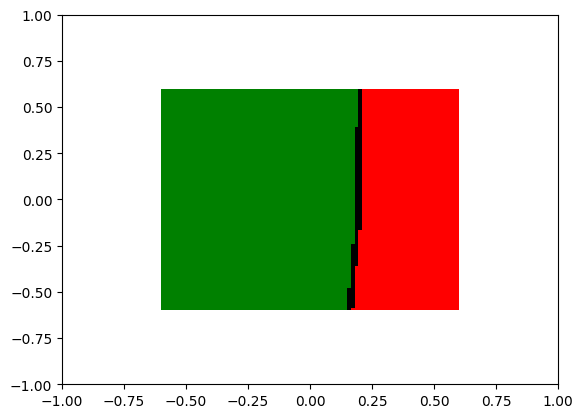

In [ ]:
scoreCon = test_an_image_concrete(x_test[0], y_test[0], probability_model, divisions = 20)
scoreAbs, noiseAbs = test_an_image_abstract(x_test[0], y_test[0], probability_model, gamma = 3)

print(f"\t\t\t ----FINAL RESULT----\n Concrete: {scoreCon} ; Abstract: [{scoreAbs},{scoreAbs + noiseAbs}]")

## Gamma Plot for Abstract

Round 0 start...
R0 -> Batch 1/2
		 3.4078946113586426
R0 -> Batch 2/2
		 0.6912276744842529
...Round 0 end


<ipython-input-29-2169830f6e85>:4: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  p,i = mvn.mvnun(input_lb[i],input_ub[i], x0, std_mat)


Round 0 start...
R0 -> Batch 1/2
		 3.6751718521118164
R0 -> Batch 2/2
		 0.7060799598693848
...Round 0 end
Round 1 start...
R1 -> Batch 1/2
		 3.4183056354522705
R1 -> Batch 2/2
		 1.2930920124053955
...Round 1 end
Round 0 start...
R0 -> Batch 1/2
		 3.4217543601989746
R0 -> Batch 2/2
		 0.6941697597503662
...Round 0 end
Round 1 start...
R1 -> Batch 1/2
		 3.4279122352600098
R1 -> Batch 2/2
		 1.2916555404663086
...Round 1 end
Round 2 start...
R2 -> Batch 1/2
		 3.413383722305298
R2 -> Batch 2/2
		 2.6046183109283447
...Round 2 end
Round 0 start...
R0 -> Batch 1/2
		 3.4183928966522217
R0 -> Batch 2/2
		 0.6882724761962891
...Round 0 end
Round 1 start...
R1 -> Batch 1/2
		 3.4182417392730713
R1 -> Batch 2/2
		 1.2822380065917969
...Round 1 end
Round 2 start...
R2 -> Batch 1/2
		 3.4117515087127686
R2 -> Batch 2/2
		 2.5969865322113037
...Round 2 end
Round 3 start...
R3 -> Batch 1/3
		 3.407567262649536
R3 -> Batch 2/3
		 4.078036546707153
R3 -> Batch 3/3
		 1.03489351272583
...Round 3

<ipython-input-30-5920f86b697d>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


Round 0 start...
R0 -> Batch 1/2
		 3.4029626846313477
R0 -> Batch 2/2
		 0.6897225379943848
...Round 0 end
Round 0 start...
R0 -> Batch 1/2
		 3.4084341526031494
R0 -> Batch 2/2
		 0.6867146492004395
...Round 0 end
Round 1 start...
R1 -> Batch 1/1
		 3.0035696029663086
...Round 1 end
Round 0 start...
R0 -> Batch 1/2
		 3.406928777694702
R0 -> Batch 2/2
		 0.6897997856140137
...Round 0 end
Round 1 start...
R1 -> Batch 1/1
		 3.0106494426727295
...Round 1 end
Round 2 start...
R2 -> Batch 1/3
		 3.414186477661133
R2 -> Batch 2/3
		 4.083385705947876
R2 -> Batch 3/3
		 1.88297700881958
...Round 2 end
Round 0 start...
R0 -> Batch 1/2
		 3.4076998233795166
R0 -> Batch 2/2
		 0.6921372413635254
...Round 0 end
Round 1 start...
R1 -> Batch 1/1
		 3.0066356658935547
...Round 1 end
Round 2 start...
R2 -> Batch 1/3
		 3.4195444583892822
R2 -> Batch 2/3
		 4.087055206298828
R2 -> Batch 3/3
		 1.8838024139404297
...Round 2 end
Round 3 start...
R3 -> Batch 1/4
		 3.4126789569854736
R3 -> Batch 2/4
	

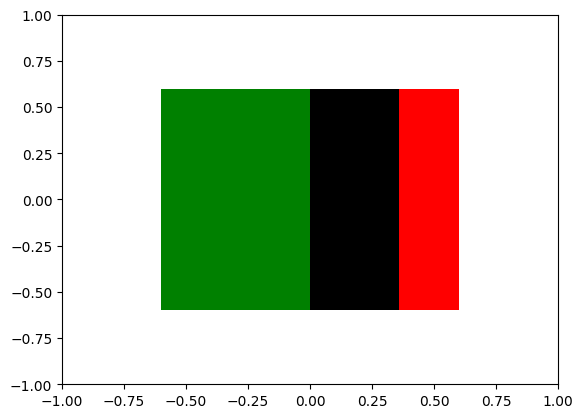

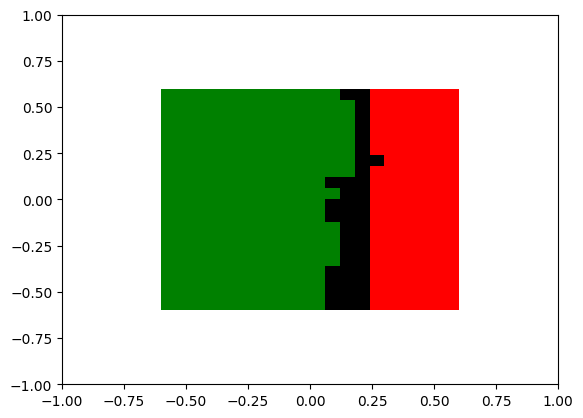

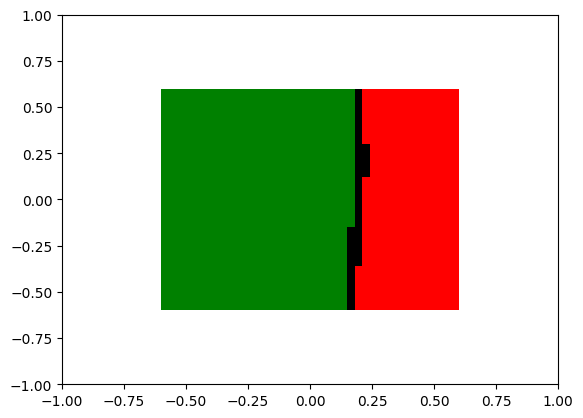

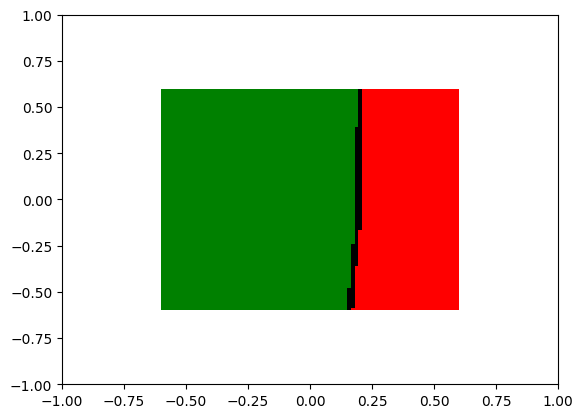

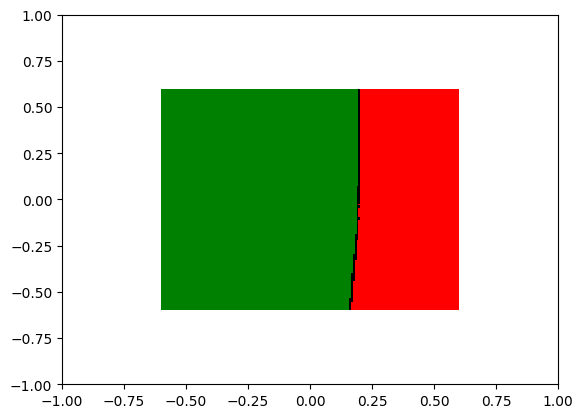

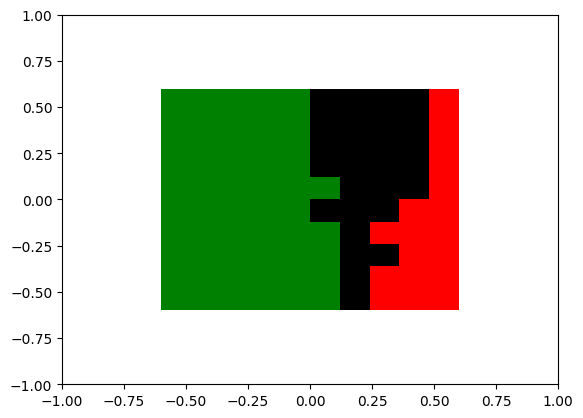

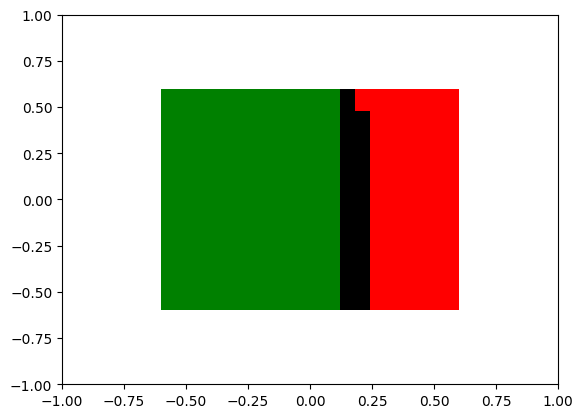

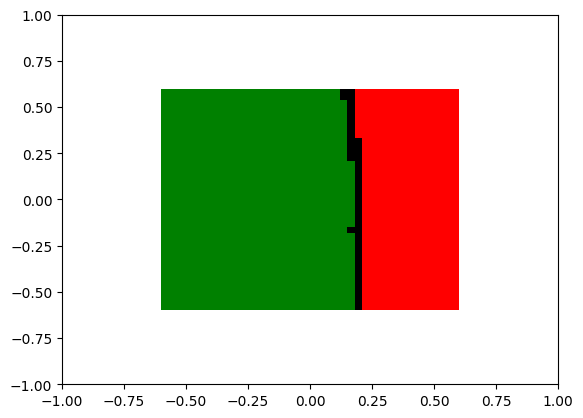

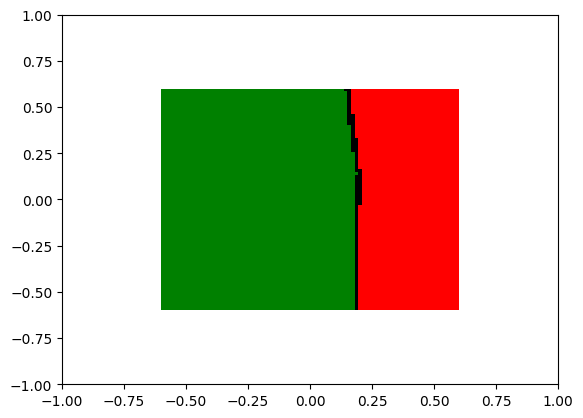

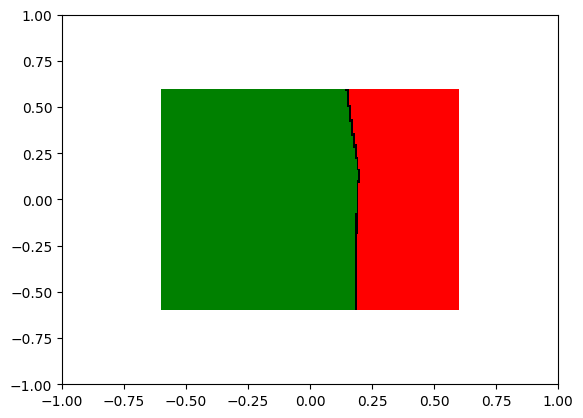

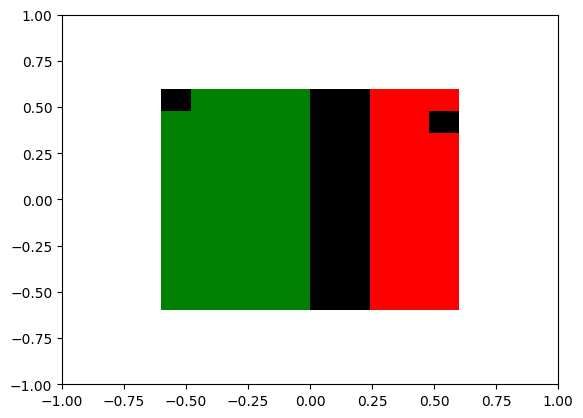

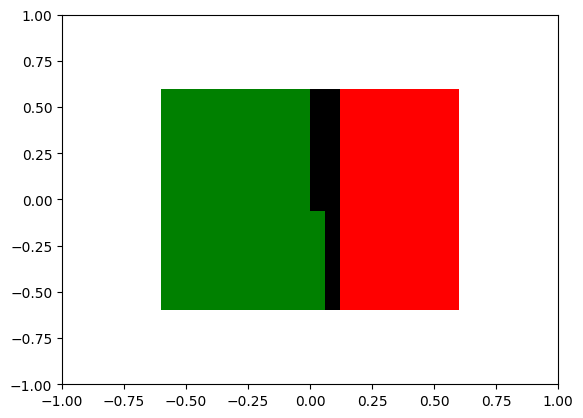

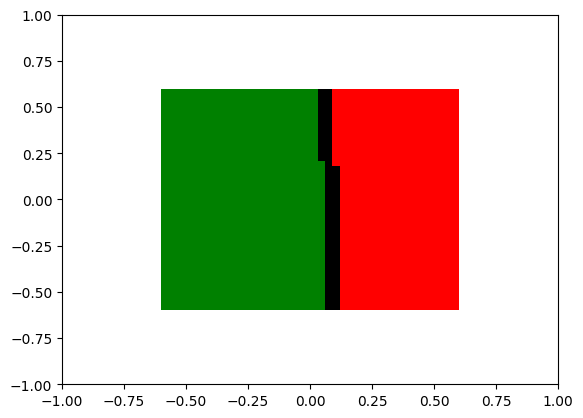

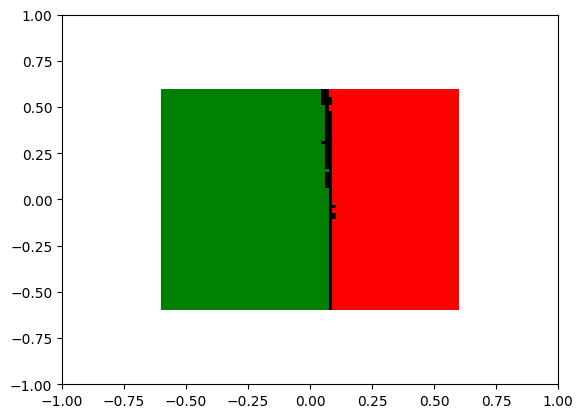

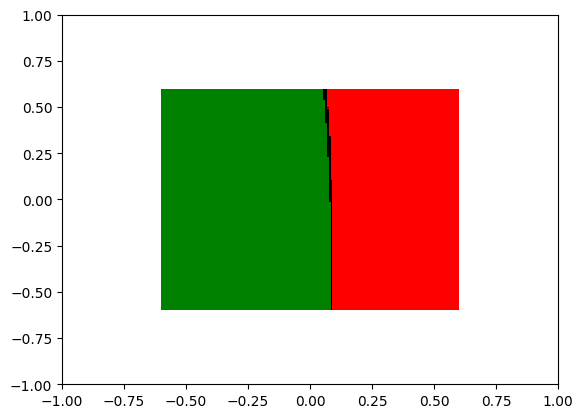

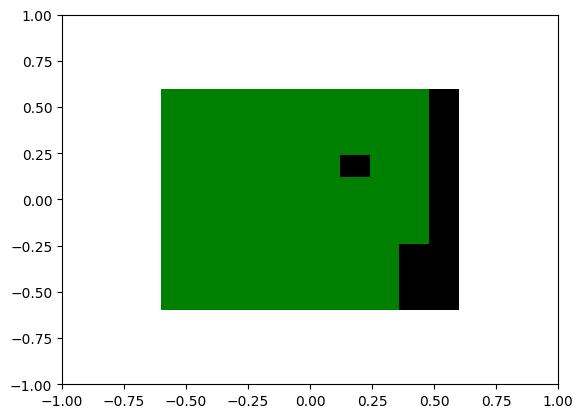

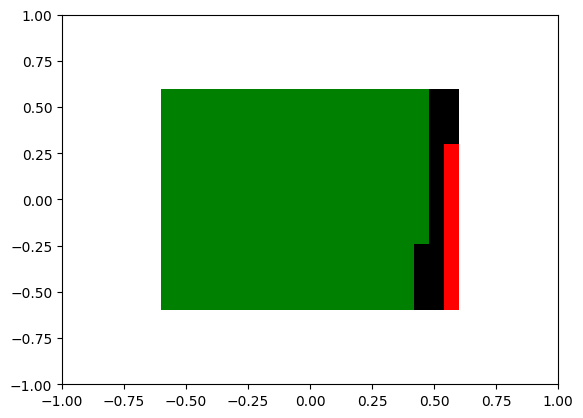

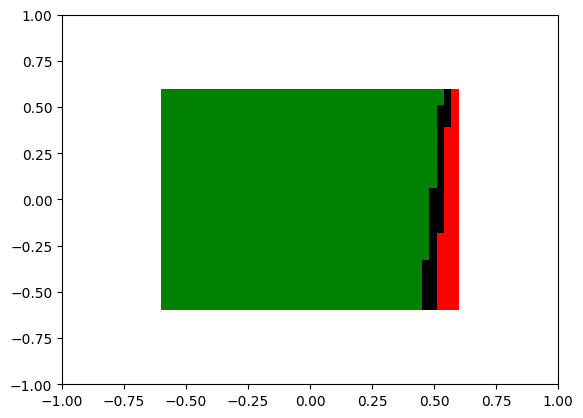

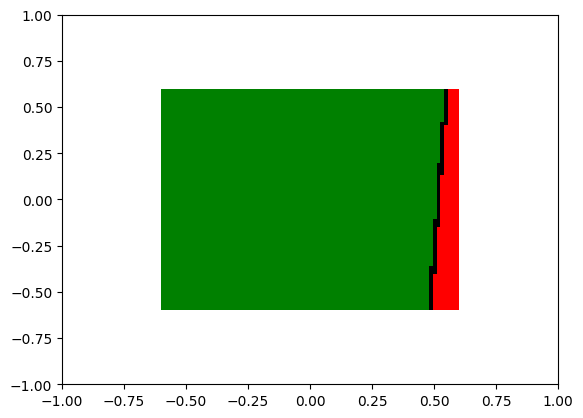

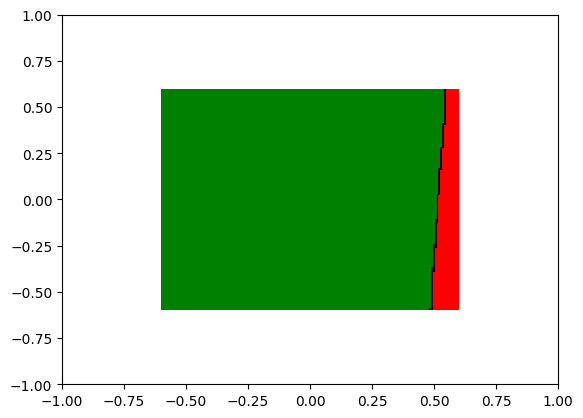

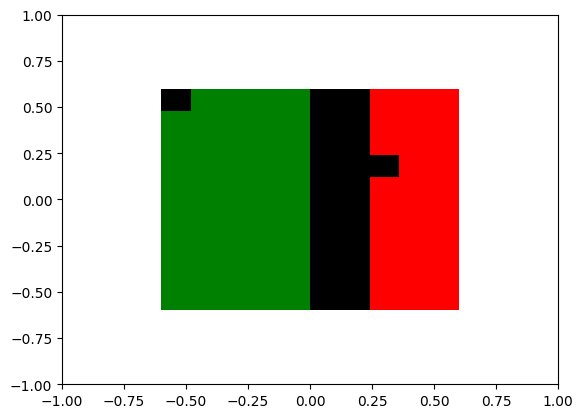

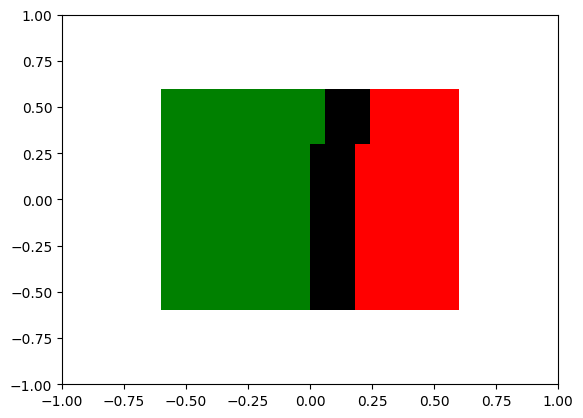

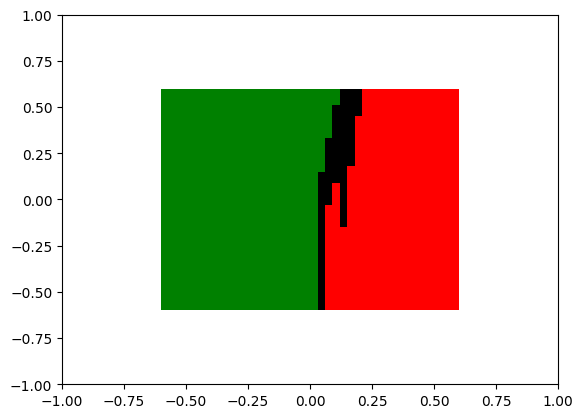

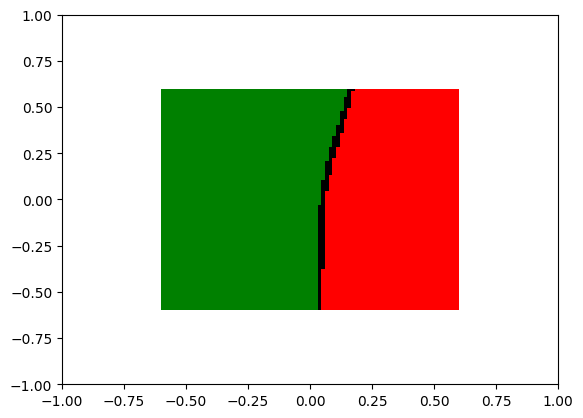

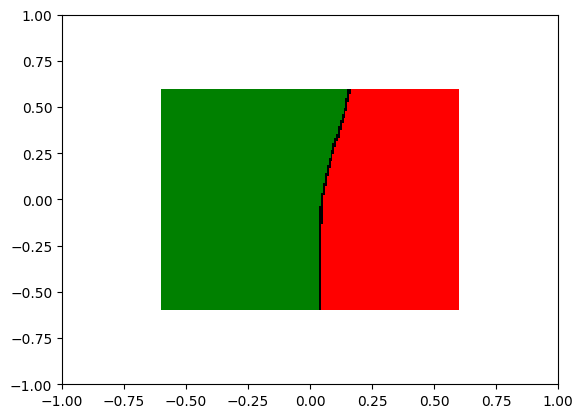

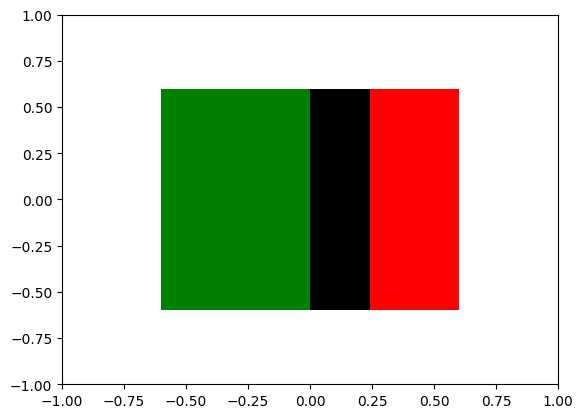

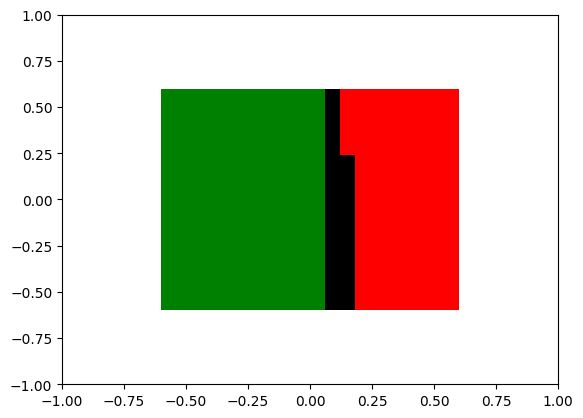

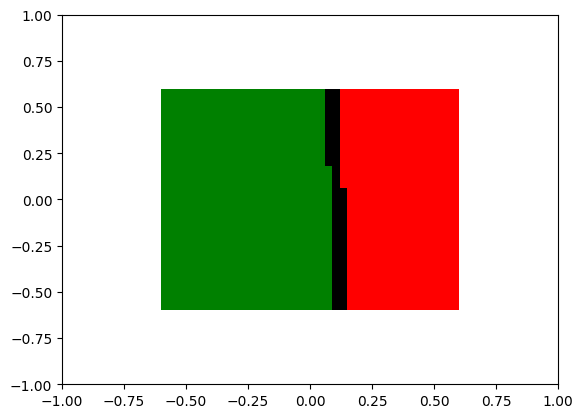

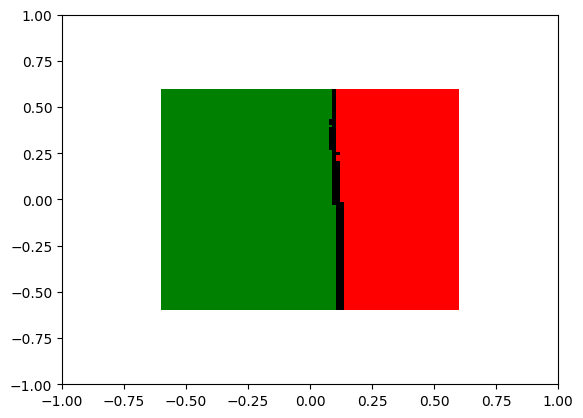

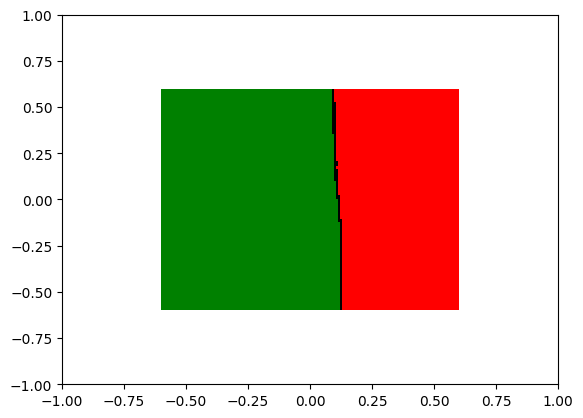

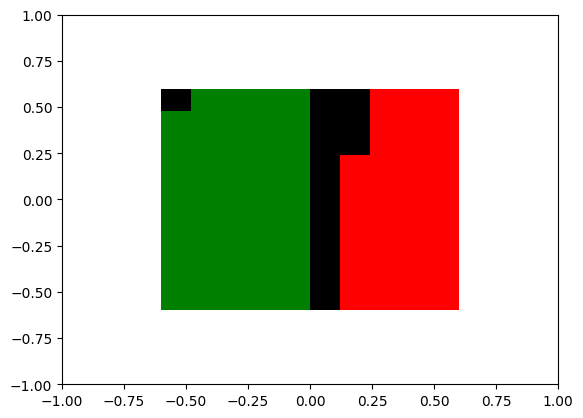

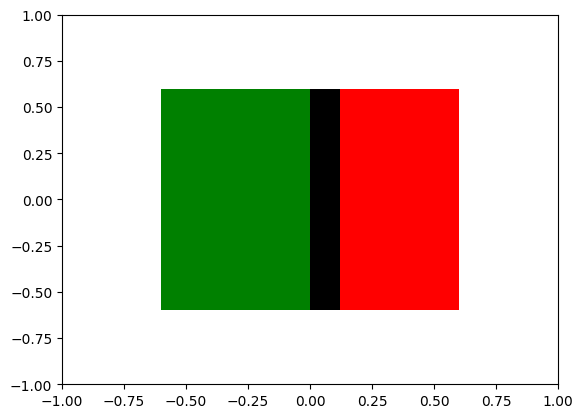

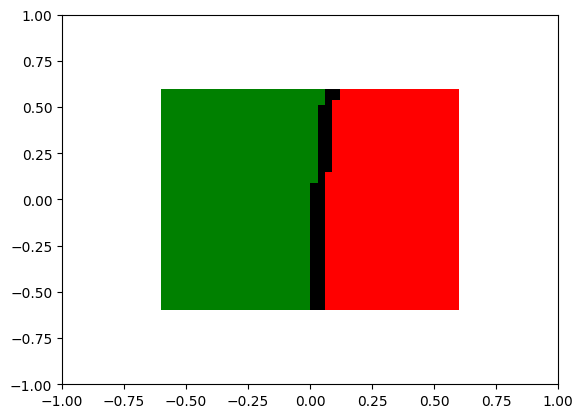

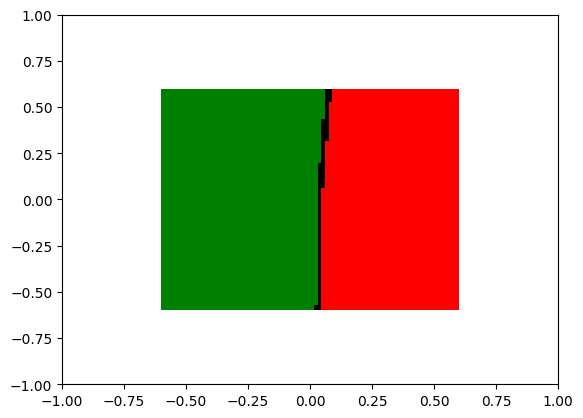

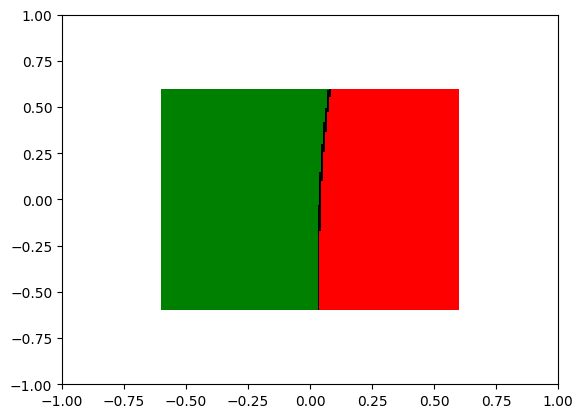

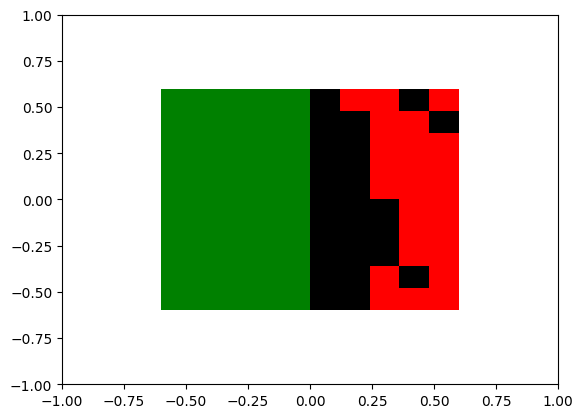

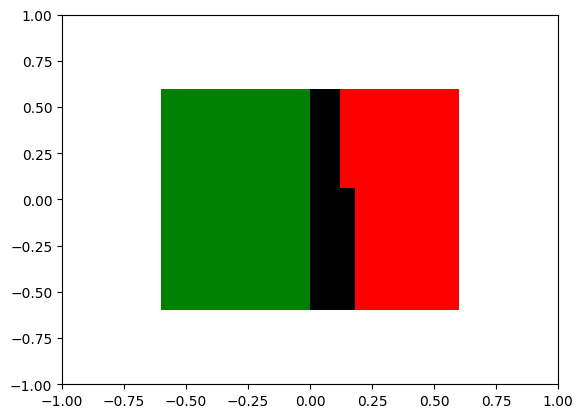

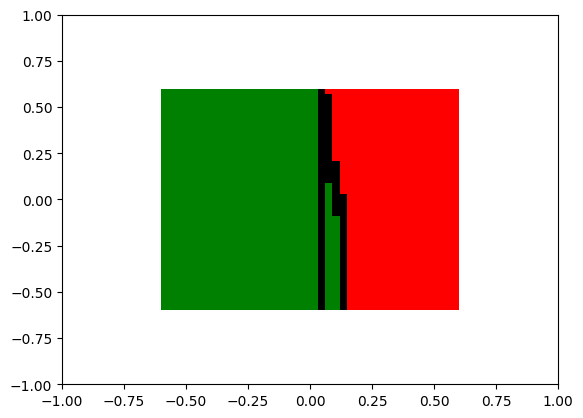

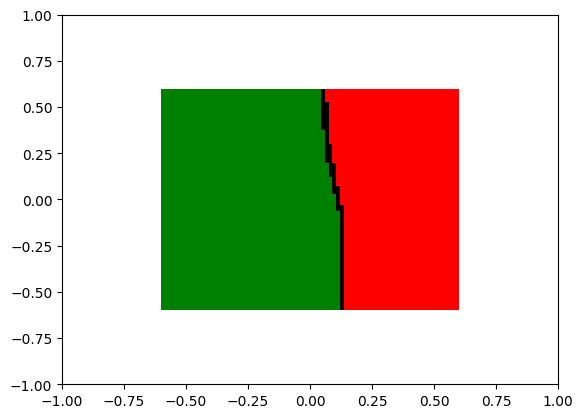

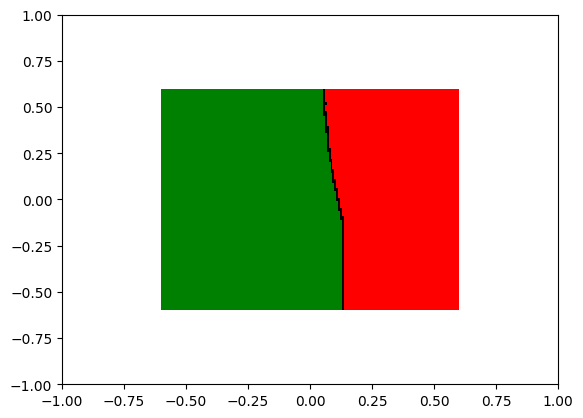

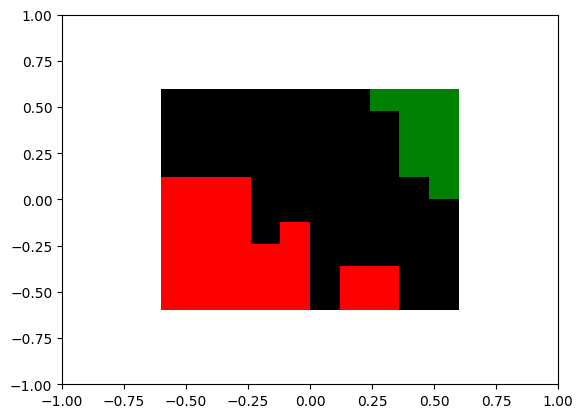

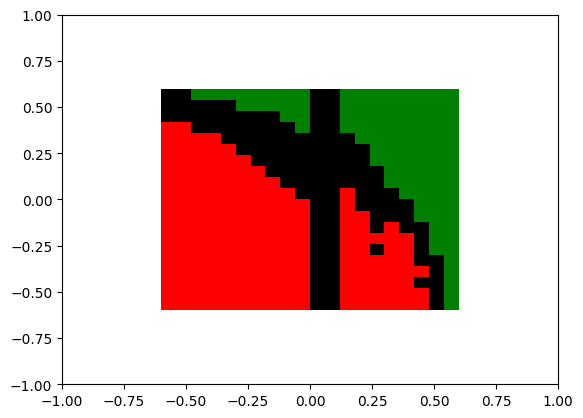

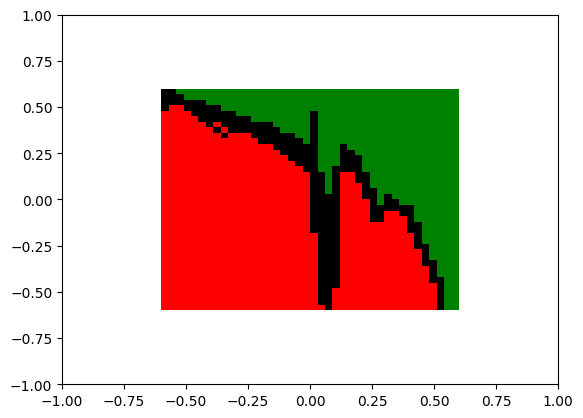

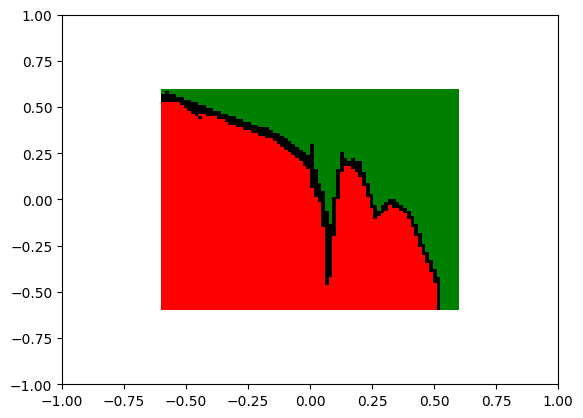

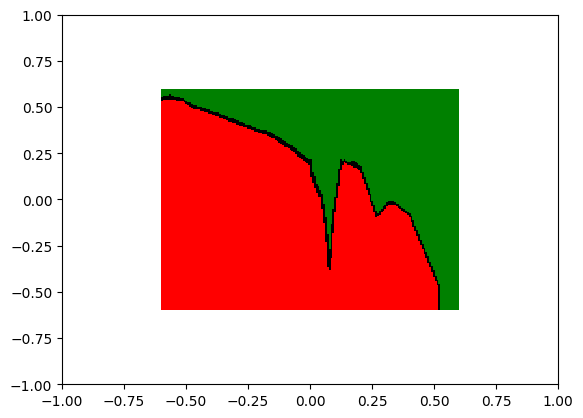

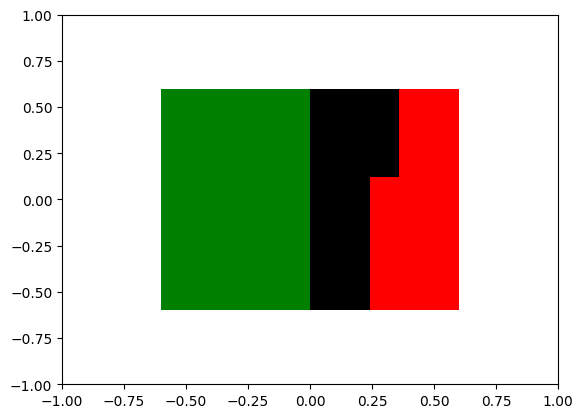

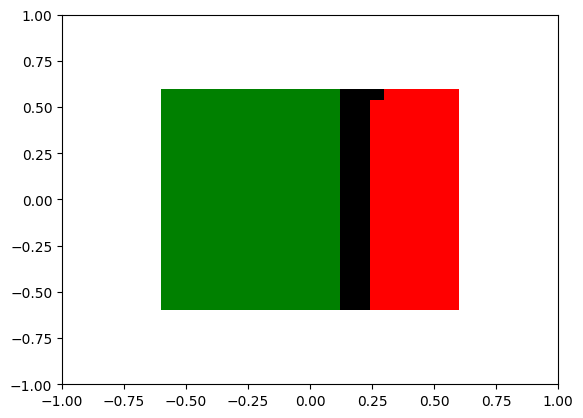

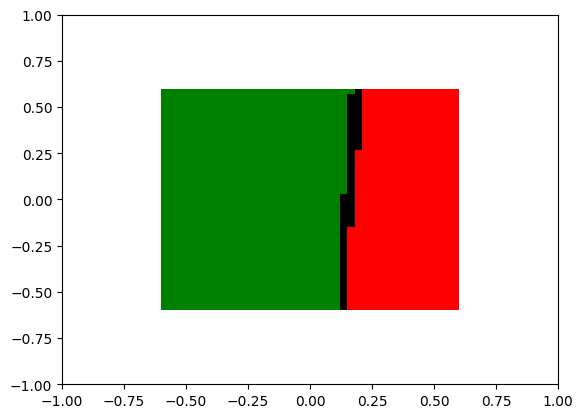

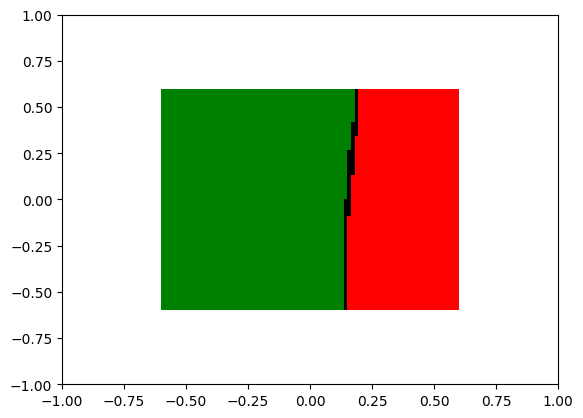

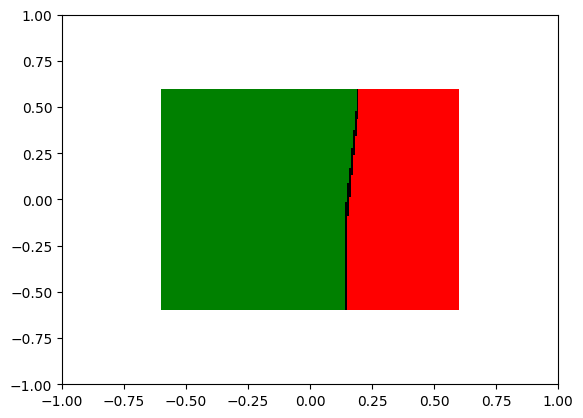

In [ ]:
gammas_a, scores_lb_a, scores_ub_a, times_a = [], [], [], []
for image_i in range(0,10):
  gammas, scores_lb, scores_ub, times = [], [], [], []
  for gam in range(0, 5):
    begin = time.time()
    scoreAbs, noiseAbs = test_an_image_abstract(x_test[image_i], y_test[image_i], probability_model, gamma = gam)
    end = time.time()
    times.append(end - begin)
    gammas.append(gam)
    scores_lb.append(scoreAbs)
    scores_ub.append(scoreAbs + noiseAbs)
  gammas_a.append(gammas)
  scores_lb_a.append(scores_lb)
  scores_ub_a.append(scores_ub)
  times_a.append(times)

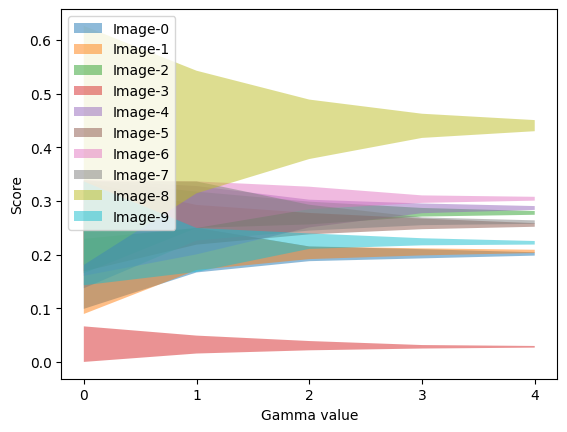

In [ ]:
plt.clf()
for i in range(len(gammas_a)):
  plt.fill_between(gammas_a[i], scores_lb_a[i], scores_ub_a[i], alpha=0.5, label = f"Image-{i}")

plt.xlabel('Gamma value')
plt.ylabel('Score')
plt.xticks(gammas_a[0])
plt.legend(loc='upper left')
plt.show()

In [ ]:
times

[4.957886457443237,
 9.008596658706665,
 16.180032968521118,
 25.98616933822632,
 43.930283308029175]

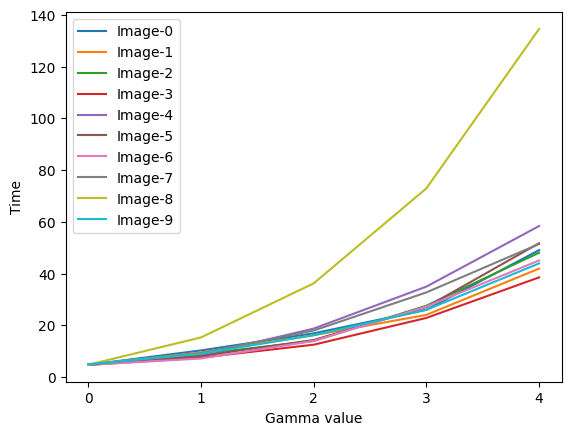

In [ ]:
plt.clf()
for i in range(len(gammas_a)):
  plt.plot(gammas_a[i], times_a[i], label = f"Image-{i}")

plt.xlabel('Gamma value')
plt.ylabel('Time')
plt.xticks(gammas_a[0])
plt.legend(loc='upper left')
plt.show()  # display

## Division Plot for Concrete

In [ ]:
divs_a, times_a, scores_a = [], [], []
for image_i in range(0,10):
  divs, times, scores = [], [], []
  for div in range(2, 50, 3):
    begin = time.time()
    scoreCon = test_an_image_concrete(x_test[image_i], y_test[image_i], probability_model, divisions = div)
    end = time.time()
    divs.append(div)
    times.append(end - begin)
    scores.append(scoreCon)
  divs_a.append(divs)
  times_a.append(times)
  scores_a.append(scores)

<ipython-input-31-2949b5ed45f3>:5: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  p,i = mvn.mvnun(input_lb[i],input_ub[i], x0, std_mat)


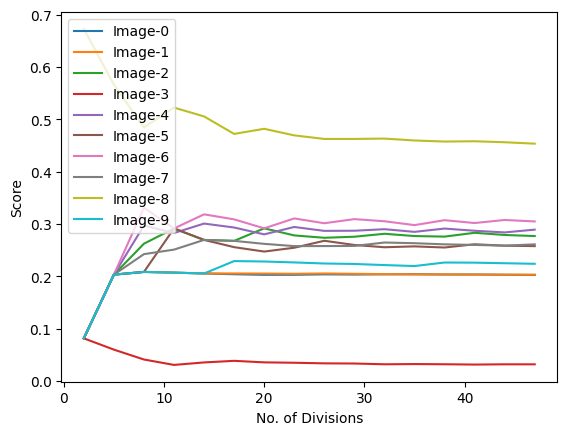

In [ ]:
plt.clf()
for i in range(len(gammas_a)):
  plt.plot(divs_a[i], scores_a[i], label = f"Image-{i}")
plt.xlabel('No. of Divisions')
plt.ylabel('Score')
plt.legend()
plt.show()  # display

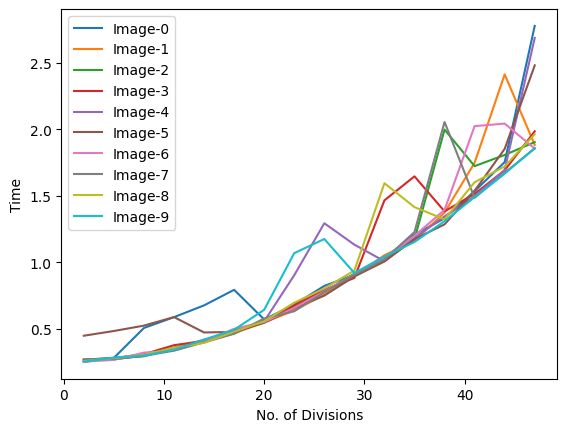

In [ ]:
plt.clf()
for i in range(len(gammas_a)):
  plt.plot(divs_a[i], times_a[i], label = f"Image-{i}")
plt.xlabel('No. of Divisions')
plt.ylabel('Time')
plt.legend()
plt.show()  # display

## **1000 images Concrete**

In [ ]:
times, scores = [], []
div = 20
for image_i in range(0,1000):
  begin = time.time()
  scoreCon = test_an_image_concrete(x_test[image_i], y_test[image_i], probability_model, divisions = div)
  end = time.time()
  times.append(end - begin)
  scores.append(scoreCon)

<ipython-input-31-2949b5ed45f3>:5: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  p,i = mvn.mvnun(input_lb[i],input_ub[i], x0, std_mat)


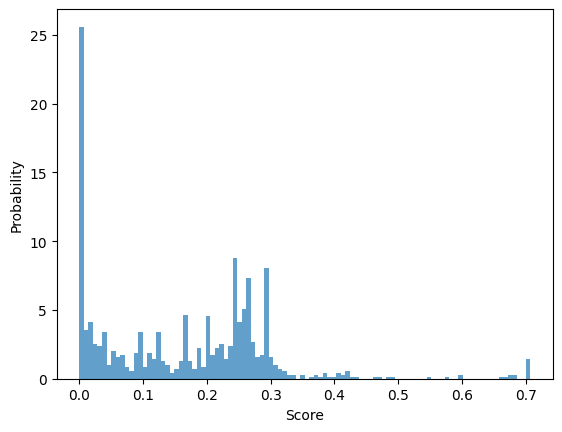

In [ ]:
plt.hist(scores, bins=100, density=True, alpha=0.7)
plt.xlabel('Score')
plt.ylabel('Probability')
plt.show()